In [7]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman

In [8]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass')
results = util.unpickle_all(save_dir, 'results_', '.pkl')

In [9]:
pprint(results[0].keys())

dict_keys(['1_511_511', '1_511_1533', '1_511_2555', '1_511_3577', '1_1533_511', '1_1533_1533', '1_1533_2555', '1_1533_3577', '1_2555_511', '1_2555_1533', '1_2555_2555', '1_2555_3577', '1_3577_511', '1_3577_1533', '1_3577_2555', '1_3577_3577', '2_511_511', '2_511_1533', '2_511_2555', '2_511_3577', '2_1533_511', '2_1533_1533', '2_1533_2555', '2_1533_3577', '2_2555_511', '2_2555_1533', '2_2555_2555', '2_2555_3577', '2_3577_511', '2_3577_1533', '2_3577_2555', '2_3577_3577', '3_511_511', '3_511_1533', '3_511_2555', '3_511_3577', '3_1533_511', '3_1533_1533', '3_1533_2555', '3_1533_3577', '3_2555_511', '3_2555_1533', '3_2555_2555', '3_2555_3577', '3_3577_511', '3_3577_1533', '3_3577_2555', '3_3577_3577', '4_511_511', '4_511_1533', '4_511_2555', '4_511_3577', '4_1533_511', '4_1533_1533', '4_1533_2555', '4_1533_3577', '4_2555_511', '4_2555_1533', '4_2555_2555', '4_2555_3577', '4_3577_511', '4_3577_1533', '4_3577_2555', '4_3577_3577', '5_511_511', '5_511_1533', '5_511_2555', '5_511_3577', '5_153

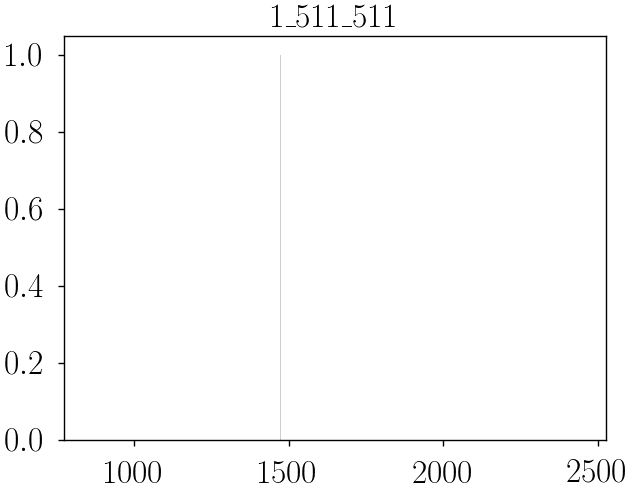

In [10]:
sample_position_key = list(results[0].keys())[0]
sample_results = results[0][sample_position_key]

mass_list, median_list, maxes, mins = [], [], [], []
for mass, chi_squared_list in sample_results.items():
    mass_list.append(mass)
    median_list.append(np.median(chi_squared_list))
    maxes.append(np.max(chi_squared_list))
    mins.append(np.min(chi_squared_list))
    if all(v == 0 for v in chi_squared_list):
        plt.axvline(0, label=f'{float(mass):.0e} M$_\odot$')
    else:
        plt.hist(chi_squared_list, label=f'{float(mass):.0e} M$_\odot$', alpha=0.5, bins=5)

uplims = np.array(maxes) - np.array(median_list)
lolims = np.array(median_list) - np.array(mins)

# plt.xscale('log')
plt.title(sample_position_key)
# plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_01_histogram.png'))
plt.show()

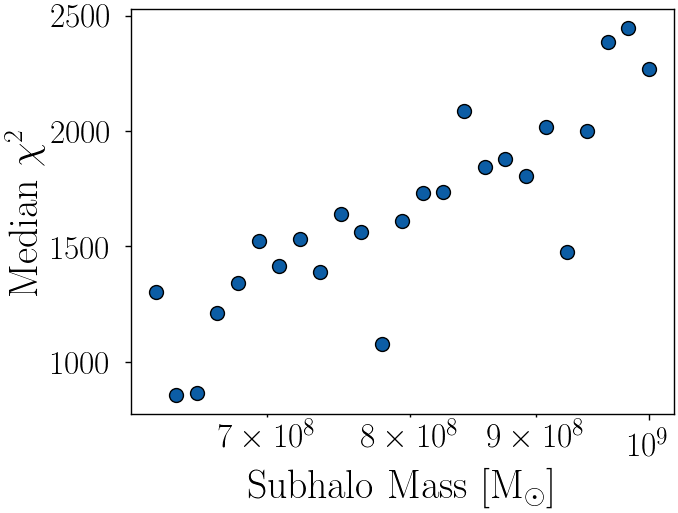

In [11]:
mass_list = [float(mass) for mass in mass_list]
plt.errorbar(mass_list, median_list, yerr=[uplims, lolims], fmt='o')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.savefig(os.path.join(figure_dir, 'ldsm_02_errorbar.png'))
plt.show()

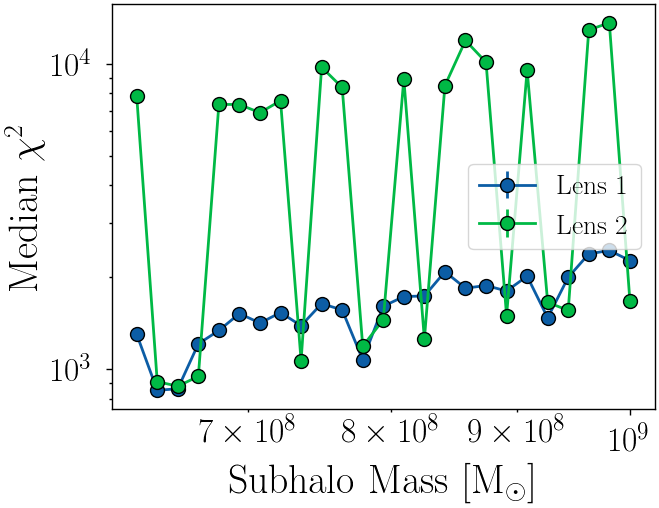

In [12]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results[:7]):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        mass_list.append(mass)
        median_list.append(np.median(chi_squared_list))
        maxes.append(np.max(chi_squared_list))
        mins.append(np.min(chi_squared_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_03_lenses.png'))
plt.show()

In [13]:
from scipy.stats import chi2

pixels = 42 ** 2
df = pixels - 3  # 3 dof: subhalo x, subhalo y, subhalo mass

rv = chi2(df)

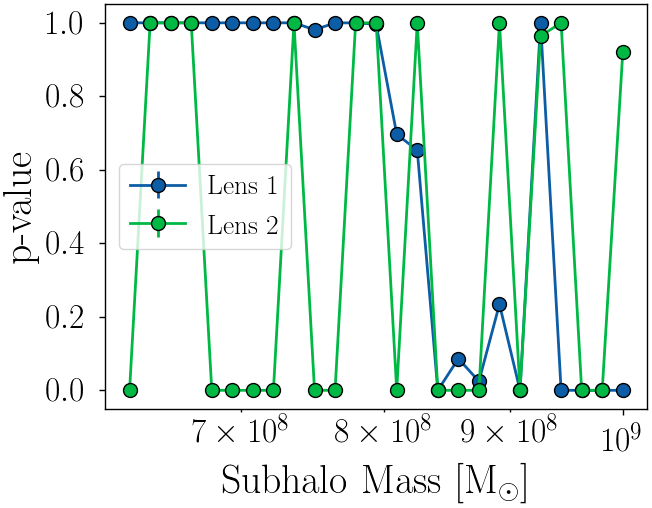

In [14]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results[:10]):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        p_list = [rv.sf(chi) for chi in chi_squared_list]
        mass_list.append(mass)
        median_list.append(np.median(p_list))
        maxes.append(np.max(p_list))
        mins.append(np.min(p_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_04_p_vals.png'))
plt.show()

In [15]:
pval_threshold = 0.001  # three sigma

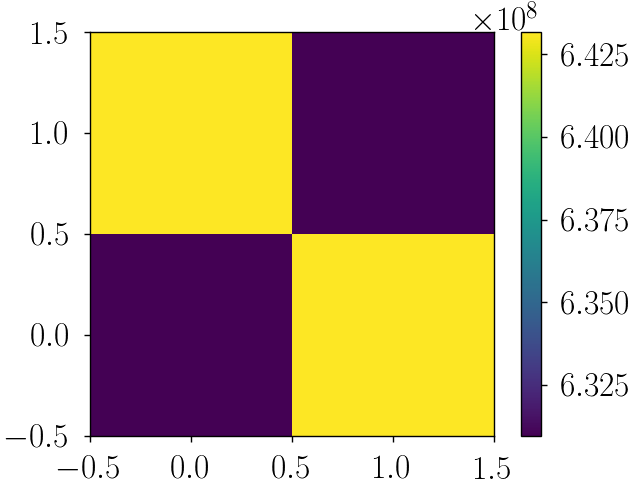

In [21]:
positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = Roman().divide_up_sca(4)
    for coord in coords:
        positions.append((sca, coord))

masses = np.logspace(8.8, 9, 25)

lens_array_list = []
sides = 2

for _, result in enumerate(results):
    current_sca = 1
    array_list = []

    # initialize the array and mass list
    array = np.zeros((sides, sides))
    mass_list = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            chi2_list = position_results[str(int(mass))]
            p_list = [rv.sf(chi) for chi in chi2_list]
            mass = float(mass)
            if np.min(p_list) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                mass_list.append(mass)
                break

        # if the last position has been reached, populate the array with the masses
        if sca_position == coords[-1]:   
            for i in range(sides):
                for j in range(sides):
                    array[i, j] = mass_list[j * sides + i]
            array_list.append(array)

            # reset the array and mass list
            array = np.zeros((sides, sides))
            mass_list = []
    
    lens_array_list.append(array_list)

plt.imshow(array_list[0], cmap='viridis')
plt.colorbar()
plt.show()

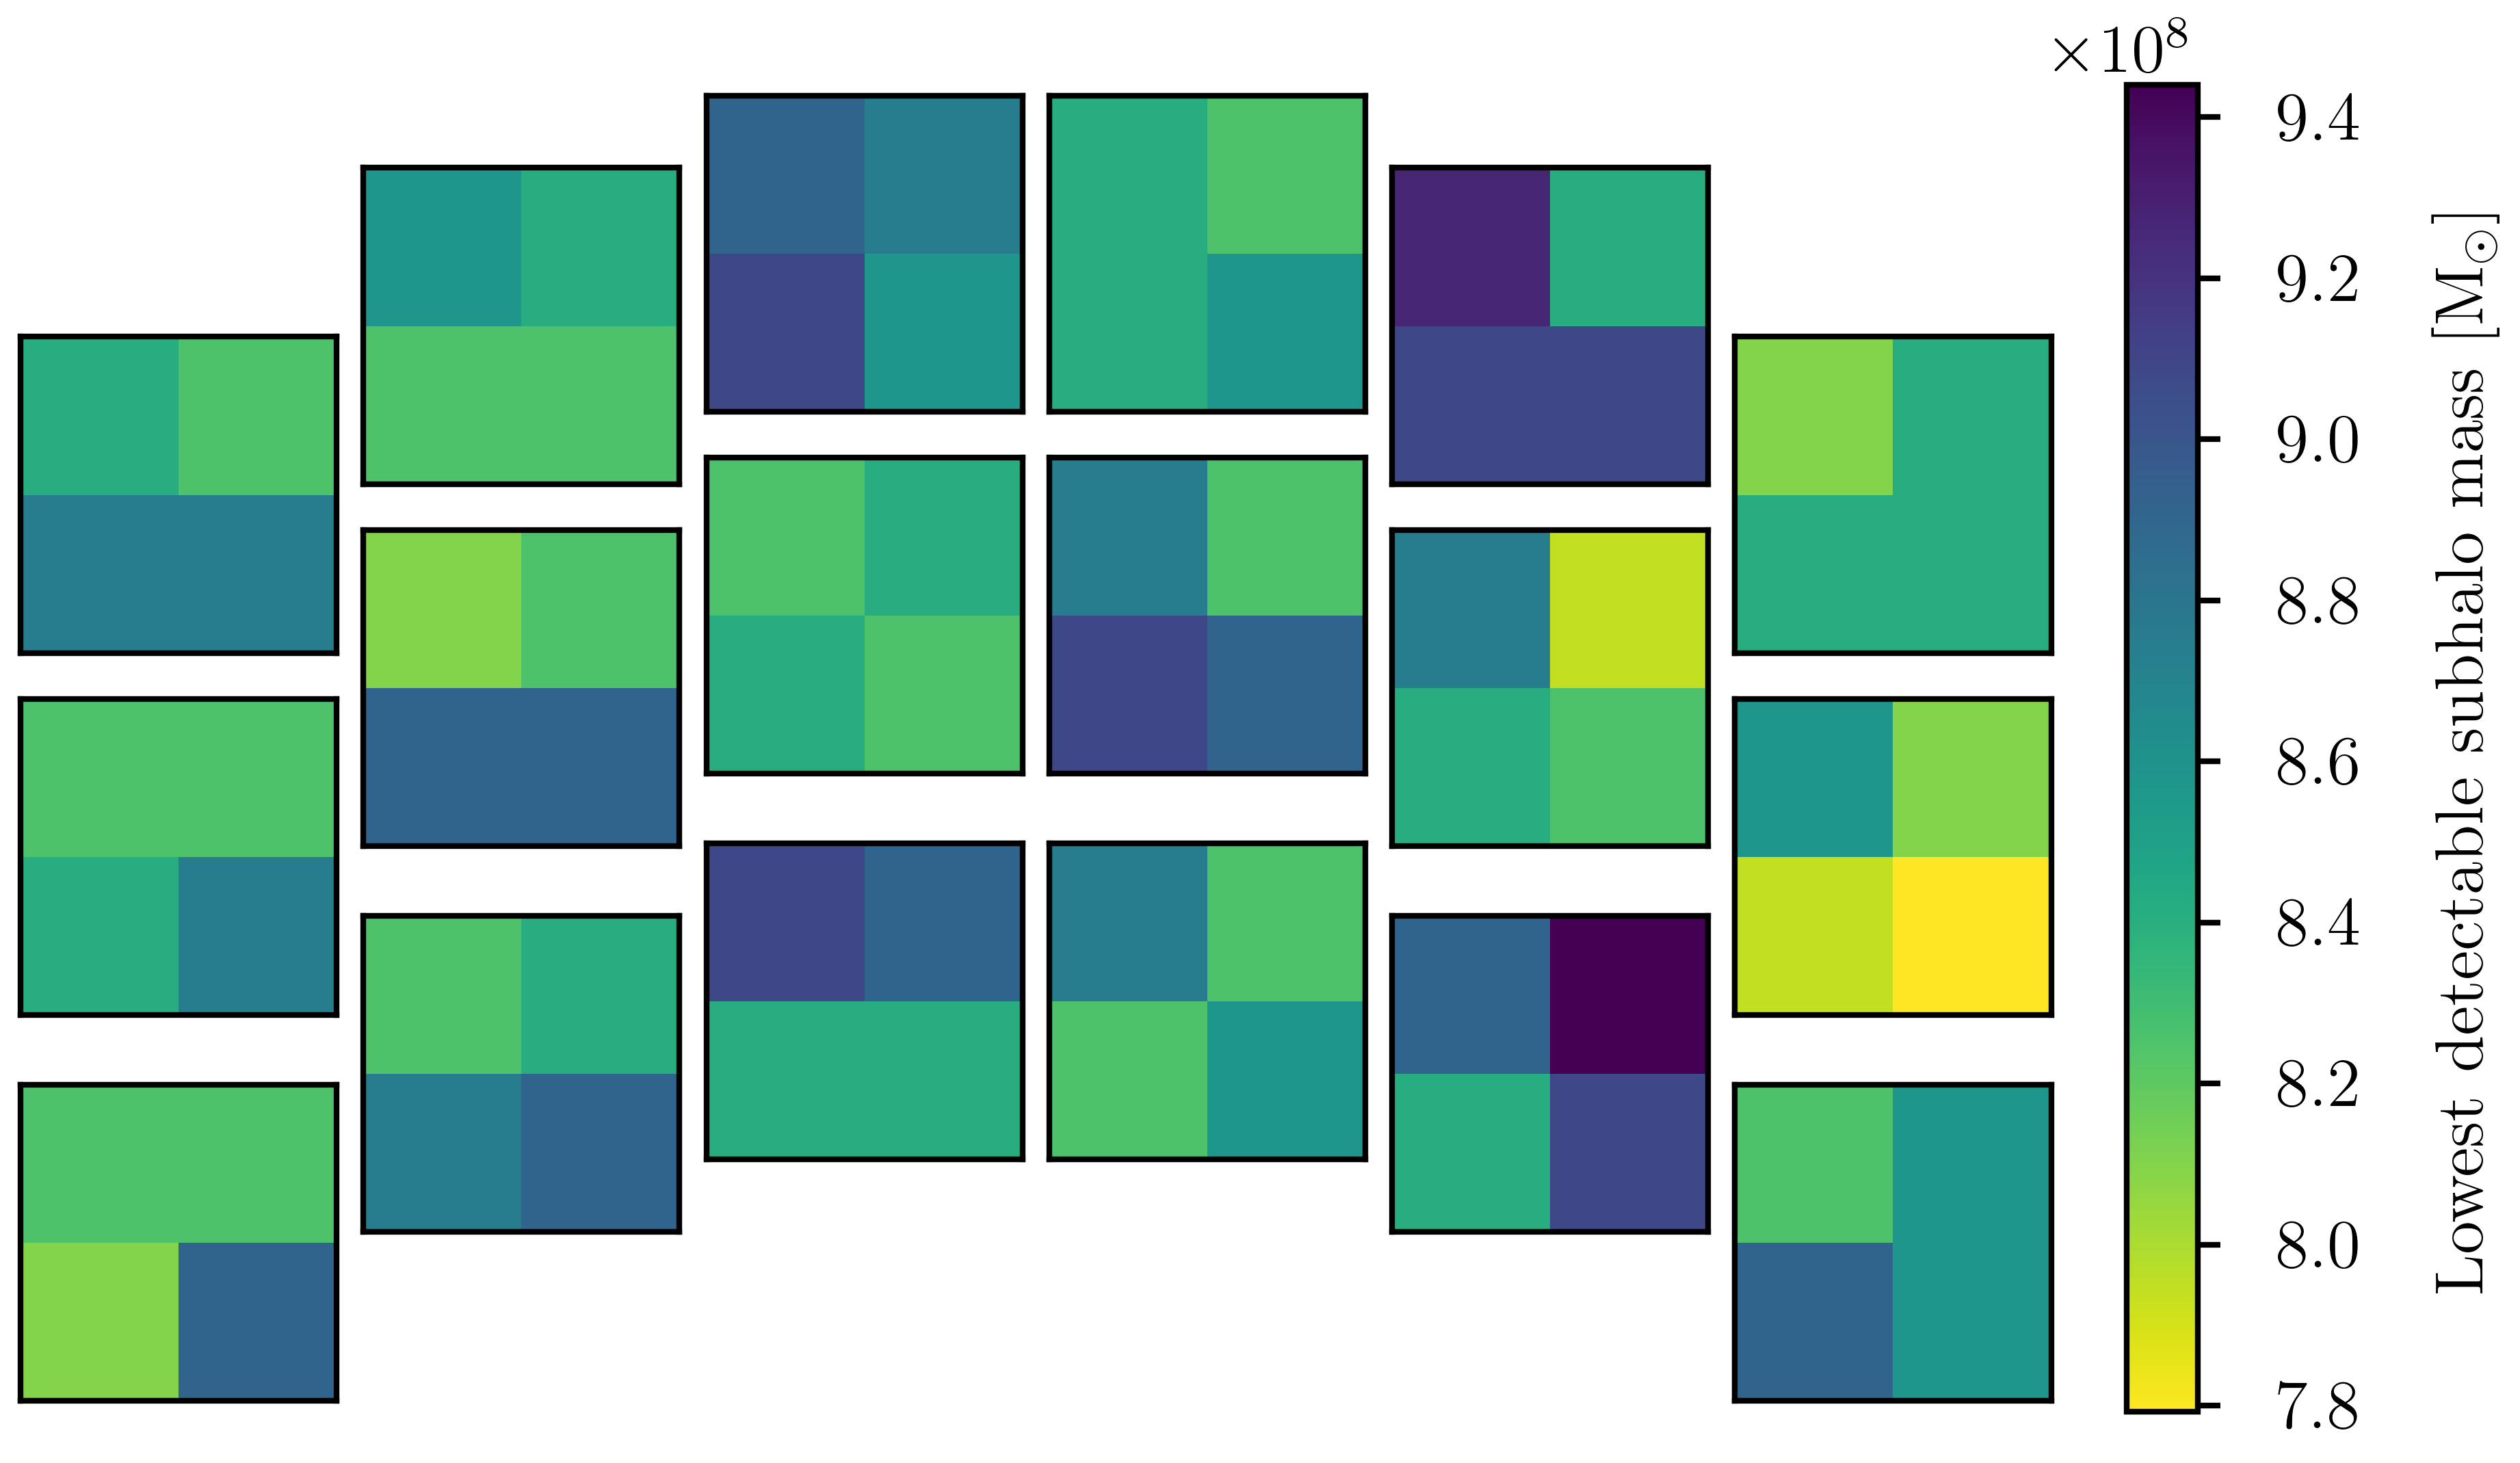

In [25]:
plotting.roman_sca_plot(np.asarray(lens_array_list[0]), 
                        np.asarray(range(1, 19)), 
                        residual_plot=False, 
                        show_sca_id=False, 
                        cmap='viridis_r', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, 'lowest_detectable_subhalo_mass_single_system.png'), 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')

In [26]:
median_array_list = []

for sca in range(1, 19):
    array = np.zeros((sides, sides))

    for i in range(sides):
        for j in range(sides):
            pixel_values = lens_array_list[sca][i][j]
            median = np.median(pixel_values)
            array[i, j] = median
    
    median_array_list.append(array)

IndexError: list index out of range

In [ ]:
plotting.roman_sca_plot(np.asarray(median_array_list), 
                        np.asarray(range(1, 19)), 
                        residual_plot=False, 
                        show_sca_id=False, 
                        cmap='viridis_r', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, 'lowest_detectable_subhalo_mass_single_system.png'), 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')